In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tfp-nightly

     |████████████████████████████████| 332.1MB 60kB/s 
     |████████████████████████████████| 61kB 24.8MB/s 
     |████████████████████████████████| 419kB 41.7MB/s 
     |████████████████████████████████| 3.0MB 39.7MB/s 
     |████████████████████████████████| 972kB 5.1MB/s 


In [0]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline



### additional material

https://www.youtube.com/watch?v=BrwKURU-wpk  

https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [0]:
lala=tfd.Normal(loc=5,scale=6)

In [6]:
lala.log_prob(np.array([3,5,7]))

<tf.Tensor: id=11, shape=(3,), dtype=float32, numpy=array([-2.7662537, -2.7106981, -2.7662537], dtype=float32)>

In [0]:

w0 = 0.125
b0 = 5.
x_range = [-100, 0]

def load_dataset(n=50, n_tst=50):
  np.random.seed(55)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [0]:

w0 = 0.125
b0 = 5.
x_range = [0, 100]

def load_dataset(n=350, n_tst=250):
  np.random.seed(22)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y_, x_, x_tst = load_dataset()
#y, x, x_tst = load_dataset()

In [0]:
x=np.concatenate((x,x_))
y=np.concatenate((y,y_))

In [55]:
print(x.shape)
print(y.shape)
print(x_tst.shape)

(400, 1)
(400,)
(250, 1)


In [0]:
#x sind randmon zahlen zwischen -20 und 60
#x test ist der range in 150 schrtten von -20 +60 
#y = (w0 * x * (1. + np.sin(x)) + b0) + eps

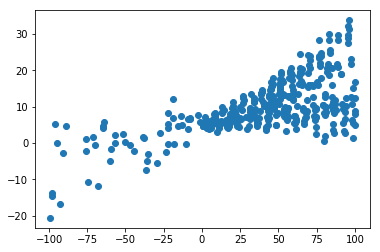

In [57]:
plt.scatter(x,y)

In [0]:
x_tst=np.arange(0,100,0.1)

### ML Estimator


In [0]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [0.13523116]
Coefficients: 
 5.128420601457348


In [0]:
#Build model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape=(1,)))
model.compile(loss='mse', optimizer="adam", metrics=['accuracy'])
model.summary()
model.fit(x,y,batch_size=150,epochs=12000,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.get_weights()

[array([[0.13853021]], dtype=float32), array([4.9734774], dtype=float32)]

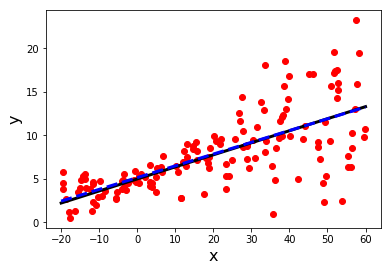

In [0]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,model.predict(x_tst),color="black",linewidth=3) #pred
plt.plot(x_tst,a_ml*x_tst+b_ml,color="blue",linewidth=3,linestyle="--") #pred
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()
#plt.scatter(x_tst,model.predict(x_tst)-2,color="blue") 
#plt.scatter(x_tst,model.predict(x_tst)+2,color="blue") 

In [0]:
print(model.predict(x_tst)[0:3])
np.random.normal(loc=model.predict(x_tst)[0:3],scale=1)

[[2.2028732]
 [2.2772517]
 [2.3516304]]


array([[0.5070647 ],
       [3.59104119],
       [2.53217631]])

## No UnC but dist as output with constant variance

In [0]:
#negloglik = lambda y, rv_y: -rv_y.log_prob(y)#define negative loglike
def negloglik(y,rv_y):
  return -rv_y.log_prob(y)

In [0]:
def dumm(t):
  return tfd.Normal(loc=t, scale=1)

In [0]:
#Build model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape=(1,)))
#model.add(tfp.layers.DistributionLambda(lambda t1: tfd.Normal(loc=t1, scale=1)))
model.add(tfp.layers.DistributionLambda(dumm))
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=0)
#model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.get_weights()

[array([[0.13759382]], dtype=float32), array([5.1389112], dtype=float32)]

In [0]:
#model.predict(x_tst[0:3])
#model

In [0]:
print(model(x_tst[0:3]).stddev())
print(model(x_tst[0:3]).mean())
print(model(x_tst[0:3]).sample())


tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[2.387035 ]
 [2.4609108]
 [2.5347867]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[2.6496673]
 [3.0862494]
 [4.1200905]], shape=(3, 1), dtype=float32)


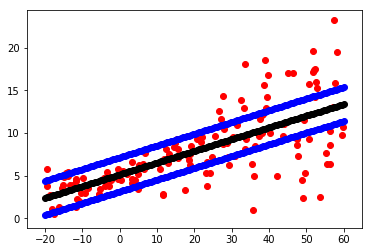

In [0]:
plt.scatter(x,y,color="red") 
plt.scatter(x_tst,model(x_tst).mean(),color="black")
plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
#plt.scatter(x,y,color="red") #observerd 
##for i in range(0,1):
##  plt.scatter(x_tst,model(x_tst).sample())
#plt.scatter(x_tst,model(x_tst).mean(),color="black")
#plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
#plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
#model(x_tst).prob(5).numpy()#prob for x test 5 to habe the value 5

### Case 2: Aleatoric Uncertainty

In [0]:
#x=np.arange(-10,10,1)
#y1= tf.math.softplus(0.05*y)
#y2=np.log(1 + np.exp(x))
#plt.scatter(x,y1)
##plt.scatter(x,y2)

In [58]:

#Build model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2,input_shape=(1,)))
model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],
                                                              scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2]))))
### neu ist das softplus nun wird var mit modelliert)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_2 (Distr ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [73]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
mu_x = tf.keras.layers.Dense(1)(inputs)
roh_x = tf.keras.layers.Dense(20,activation="relu")(inputs)
roh_x = tf.keras.layers.Dense(1)(roh_x)
xx = tf.keras.layers.Concatenate()([mu_x,roh_x])

predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(xx)

model = Model(inputs=inputs, outputs=predictions)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 20)           40          input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1)            2           input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            21          dense_7[0][0]                    
____________________________________________________________________________________________

In [0]:
model.fit(x, y, epochs=2000, verbose=False);


In [75]:
model.get_weights()

[array([[ 2.7104697e-01,  2.0655458e-01, -2.0635731e-03,  3.6084943e-02,
          4.7411031e-01,  9.7469270e-01,  5.9512365e-01, -1.0631593e+00,
          7.5440466e-01, -1.1977378e+00,  5.1220208e-01, -2.3086880e-01,
          3.7965119e-01,  5.2429251e-02, -6.6658735e-01,  3.1497539e-04,
         -1.1045623e+00, -4.5747545e-01,  2.1286869e-01, -5.1286858e-01]],
       dtype=float32),
 array([ 0.8552627 ,  0.69046324, -0.20470843, -0.32607925, -0.4302384 ,
        -0.08115356, -0.54758966,  4.3652034 , -0.5914328 ,  4.7140856 ,
        -0.4498335 ,  1.4995316 , -0.3688977 , -0.46284246,  3.2036493 ,
        -0.06009077,  4.3735757 , -3.557651  ,  0.73193496, -3.9550257 ],
       dtype=float32),
 array([[0.12095561]], dtype=float32),
 array([5.0531564], dtype=float32),
 array([[-0.20582353],
        [-0.23304366],
        [-0.13653393],
        [-0.16828458],
        [ 0.64169437],
        [ 0.41246766],
        [ 0.14869234],
        [ 0.8147453 ],
        [ 0.7308254 ],
        [ 0.

In [76]:
print(model(x_tst[0:1]).mean())
print(model(x_tst[0:1]).stddev())

tf.Tensor([[-19.137966]], shape=(1, 1), dtype=float32)
tf.Tensor([[19.777536]], shape=(1, 1), dtype=float32)


In [0]:
#print(x_tst[0:1]*0.12251923+5.202958)
#print(tf.math.softplus(0.05*(x_tst[0:1]*1.0129702 +16.956917)))

In [0]:
x_tst=np.arange(-100,100,0.1)

In [0]:
x_tst=x_tst.reshape((len(x_tst),1))

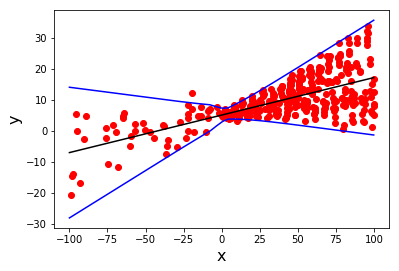

In [80]:
plt.scatter(x,y,color="red") #observerd 
#for i in range(0,3):
# plt.scatter(x_tst,model(x_tst).sample())
plt.plot(x_tst,model(x_tst).mean(),color="black")
plt.plot(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
plt.plot(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## start ani

In [0]:
import matplotlib.animation as manimation

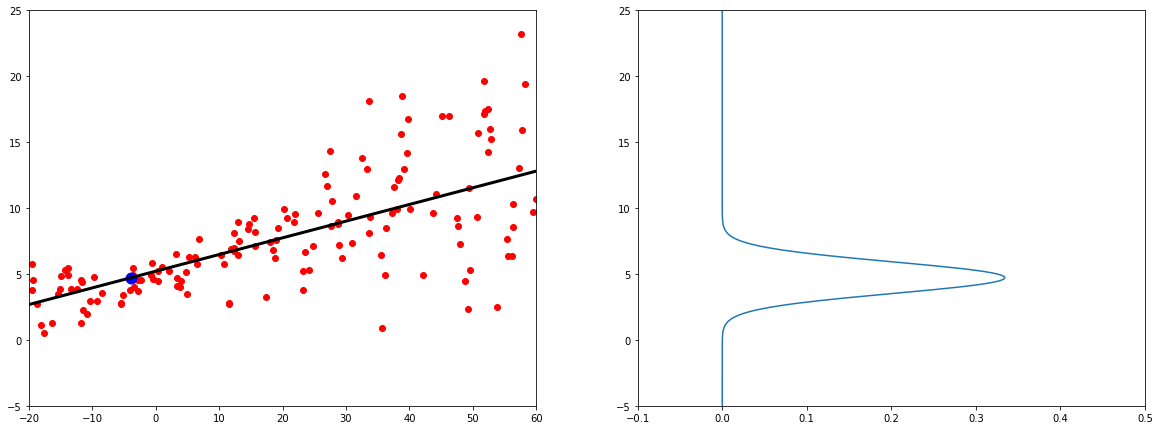

In [0]:
i=30
plt.figure(figsize=(20,16))
plt.subplot(2, 2, 1)
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,model(x_tst).mean(),color="black",linewidth=3)
plt.scatter(x_tst[i],model(x_tst[i:(i+1)]).mean(),color="blue",s=120)
plt.ylim([-5,25])
plt.xlim([-20,60])
plt.subplot(2, 2, 2)
lala=np.arange(-5,25,0.1)
lala2= model(x_tst[i:(i+1)]).prob(lala)
lala2= lala2.numpy()
lala2= lala2.reshape(lala.shape,)
plt.plot(lala2,lala)
plt.ylim([-5,25])
plt.xlim([-0.1,0.5])
plt.show()

In [0]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=4, metadata=metadata)

#with writer.saving(fig, "writer_test.mp4", 100):
#    for i in range(100):
#        x0 += 0.1 * np.random.randn()
#        y0 += 0.1 * np.random.randn()
#        l.set_data(x0, y0)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<Figure size 1440x1152 with 0 Axes>

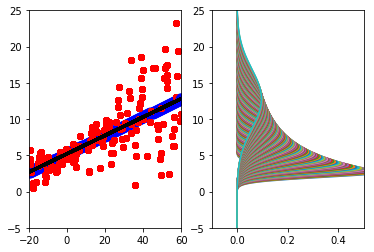

In [0]:


plt.figure(figsize=(20,16))
with writer.saving(plt.figure(), "writer_test.mp4", 400):
  for i in range(0,len(x_tst)):
    plt.subplot(1, 2, 1)
    plt.scatter(x,y,color="red") #observerd 
    plt.plot(x_tst,model(x_tst).mean(),color="black",linewidth=3)
    plt.scatter(x_tst[i],model(x_tst[i:(i+1)]).mean(),color="blue",s=120)
    plt.ylim([-5,25])
    plt.xlim([-20,60])
    plt.subplot(1, 2, 2)
    lala=np.arange(-5,25,0.1)
    lala2= model(x_tst[i:(i+1)]).prob(lala)
    lala2= lala2.numpy()
    lala2= lala2.reshape(lala.shape,)
    plt.plot(lala2,lala)
    plt.ylim([-5,25])
    plt.xlim([-0.1,0.5])
    #plt.close()
    writer.grab_frame()

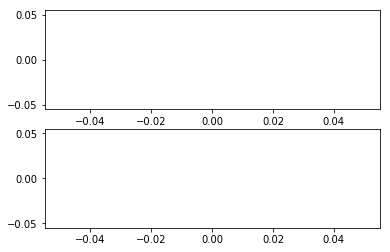

In [0]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
line = [line1, line2]

(-5, 25)

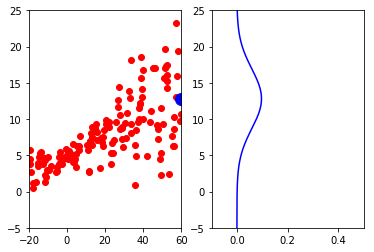

In [0]:

fig, (ax1, ax2) = plt.subplots(1,2)


l, = ax1.plot([], [],'ro',color="blue",marker='o',markersize=12)
l2, = ax2.plot([], [],color="blue")


ax1.scatter(x,y,color="red") #observerd  ### static
l.set_data(x_tst[i],model(x_tst[i:(i+1)]).mean()) # diffrent at every frame!
ax1.set_xlim([-20,60])
ax1.set_ylim([-5,25])
lala2= model(x_tst[i:(i+1)]).prob(lala)
lala2= lala2.numpy()
lala2= lala2.reshape(lala.shape,)
l2.set_data(lala2,lala)# diffrent at every frame!
ax2.set_xlim([-0.1,0.5])
ax2.set_ylim([-5,25])
#

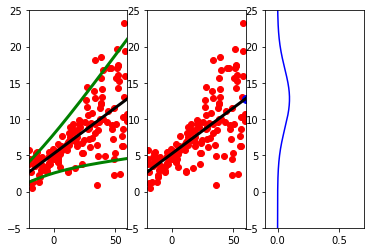

In [0]:


## final solution!!! takes like 7mins maybe the fixed suff does not need to be in the loop


fig, (ax1, ax2, ax3) = plt.subplots(1,3)


l, = ax2.plot([], [],'ro',color="blue",marker='o',markersize=8)

l2, = ax3.plot([], [],color="blue")
lala=np.arange(-5,25,0.1)

## static
ax1.scatter(x,y,color="red") #observerd  ### static
ax1.plot(x_tst,model(x_tst).mean(),color="black",linewidth=3)
ax1.plot(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="green",linewidth=3)
ax1.plot(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="green",linewidth=3)
ax1.set_xlim([-20,60])
ax1.set_ylim([-5,25])    
ax2.scatter(x,y,color="red") #observerd  ### static
ax2.plot(x_tst,model(x_tst).mean(),color="black",linewidth=3)
ax2.set_xlim([-20,60])
ax2.set_ylim([-5,25])

## ani
with writer.saving(fig, "writer_test.mp4", 600):
  for i in range(0,len(x_tst)):
  #for i in range(0,20):
    l.set_data(x_tst[i],model(x_tst[i:(i+1)]).mean()) # diffrent at every frame!
    lala2= model(x_tst[i:(i+1)]).prob(lala)
    lala2= lala2.numpy()
    lala2= lala2.reshape(lala.shape,)
    l2.set_data(lala2,lala)# diffrent at every frame!
    ax3.set_xlim([-0.1,0.7])
    ax3.set_ylim([-5,25])
    writer.grab_frame()

In [0]:
from google.colab import files
files.download('writer_test.mp4')

(-0.1, 0.5)

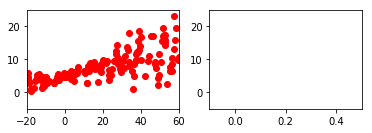

In [0]:
fig = plt.figure()
l, = plt.plot([], [],'ro',color="blue",marker='o',markersize=12)

l, = plt.plot([], [],color="blue")

lala=np.arange(-5,25,0.1)

plt.subplot(2,2,1)
plt.scatter(x,y,color="red") #observerd  ### static
l.set_data(x_tst[i],model(x_tst[i:(i+1)]).mean()) # diffrent at every frame!
plt.ylim([-5,25])
plt.xlim([-20,60])
plt.subplot(2,2,2)
lala2= model(x_tst[i:(i+1)]).prob(lala)
lala2= lala2.numpy()
lala2= lala2.reshape(lala.shape,)
l2.set_data(lala2,lala)# diffrent at every frame!
plt.ylim([-5,25])
plt.xlim([-0.1,0.5])


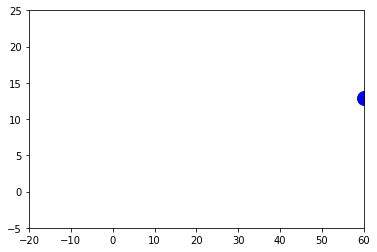

In [0]:
l, = plt.plot([], [],'ro',color="red",marker='o')
plt.ylim([-5,25])
plt.xlim([-20,60])
l.set_data(x,y)
l.set_color("blue")
l.set_markersize(14)
l.set_data(x_tst[i],model(x_tst[i:(i+1)]).mean())
#

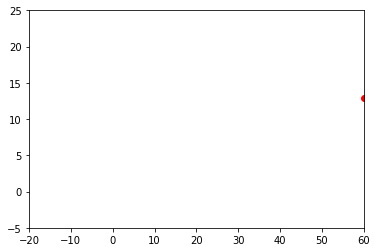

In [0]:
£l, = plt.plot([], [],'ro',color="red",marker='o')
l.set_data(x_tst[i],model(x_tst[i:(i+1)]).mean())
plt.ylim([-5,25])
plt.xlim([-20,60])



In [0]:
#l, = plt.plot([], [],'ro',color="red",marker='o')
#l.set_data(x,y)
#plt.ylim([-5,25])
#plt.xlim([-20,60])

In [0]:
#£ly[0]

In [0]:
#l= plt.scatter([], [], s=100)
#l.set_array(x)

In [0]:
from google.colab import files

# e.g. save pandas output as csv
#dataframe.to_csv('example.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('writer_test.mp4')

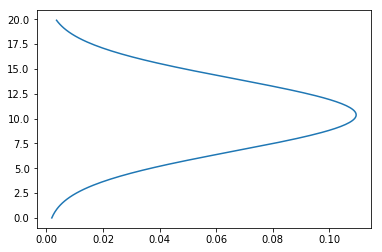

In [0]:
lala=np.arange(0,20,0.1)
lala2= model(np.array([[40]])).prob(lala)
lala2= lala2.numpy()
lala2= lala2.reshape(200,)
plt.plot(lala2,lala)

## endi ani

### Case 3: Epistemic Uncertainty

In [81]:
#Build model.
model = tf.keras.Sequential()
model.add(tfp.layers.DenseFlipout(1,
                                  bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                                  bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                                  input_shape=(1,),))
model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t,scale=1)))
#model.add(tf.keras.layers.Dense(1))
#weights haben nun eine dist und output ist auch eine dist mit konst sd=1
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout (DenseFlipout) (None, 1)                 4         
_________________________________________________________________
distribution_lambda_5 (Distr ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [0]:
#model.fit(x, y, epochs=3000, verbose=0)


In [0]:
model.get_weights()

[array([[0.20817147]], dtype=float32),
 array([[-3.4149866]], dtype=float32),
 array([1.880283], dtype=float32),
 array([0.03605013], dtype=float32)]

In [0]:
model(x_tst).mean()

<tf.Tensor 'mul_3:0' shape=(150, 1) dtype=float32>

In [116]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
xx = tfp.layers.DenseFlipout(30,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)

xx = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(xx)


xx = tfp.layers.DenseFlipout(1,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(xx)



predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t,scale=1))(xx)

model = Model(inputs=inputs, outputs=predictions)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout_5 (DenseFlipou (None, 30)                120       
_________________________________________________________________
dense_flipout_6 (DenseFlipou (None, 20)                1240      
_________________________________________________________________
dense_flipout_7 (DenseFlipou (None, 1)                 42        
_________________________________________________________________
distribution_lambda_8 (Distr ((None, 1), (None, 1))    0         
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(x, y,batch_size=32 ,epochs=2000, verbose=0)


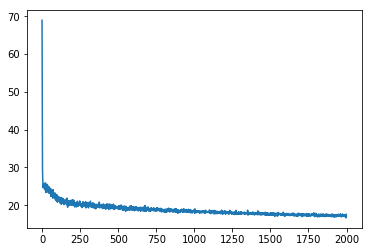

In [118]:
plt.plot(history.history['loss'])

In [0]:
#model.get_weights()

In [0]:
model_mean = tf.keras.models.Model(inputs=inputs, outputs=predictions.mean())
model_std = tf.keras.models.Model(inputs=inputs, outputs=predictions.stddev())

In [0]:
#model_mean.get_weights()

In [122]:
for i in range(0,5):
  print(model_mean.predict(x_tst[0:1]))

[[-6.702753]]
[[-8.909758]]
[[-4.9789753]]
[[-8.2707615]]
[[-7.163124]]


In [123]:
!pip install tqdm
from tqdm import tqdm_notebook as tqdm



In [0]:
x_tst=np.arange(-200,200,0.5)

In [129]:
n=5000
n_preds=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model_mean.predict(x_tst,batch_size=150),len(x_tst))

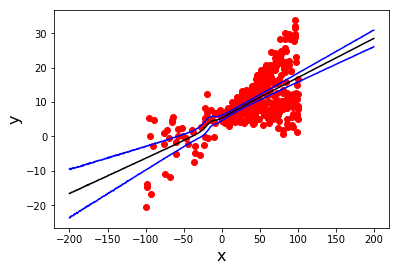

In [130]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,np.mean(n_preds,axis=0),color="black")
plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="blue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

## do the same with mc-d

In [131]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model



# This returns a tensor
inputs = Input(shape=(1,))
xx = tf.keras.layers.Dropout(0.2)(inputs, training=True)
xx = tf.keras.layers.Dense(30,activation="relu")(xx)
xx = tf.keras.layers.Dropout(0.2)(xx, training=True)
xx = tf.keras.layers.Dense(20,activation="relu")(xx)
xx = tf.keras.layers.Dropout(0.2)(xx, training=True)
xx = tf.keras.layers.Dense(1)(xx)



model = Model(inputs=inputs, outputs=xx)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss="mse")

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)                60        
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 21 

In [0]:
history=model.fit(x, y,batch_size=32 ,epochs=2000, verbose=0)


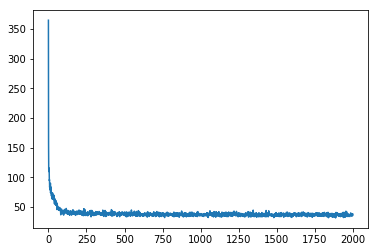

In [133]:
plt.plot(history.history['loss'])

In [134]:
for i in range(0,5):
  print(model.predict(x_tst[0:1]))

[[-26.610775]]
[[-13.85657]]
[[7.7943068]]
[[-22.29554]]
[[-20.557037]]


In [0]:
x_tst=np.arange(-200,200,0.5)

In [136]:
n=5000
n_preds=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model.predict(x_tst,batch_size=150),len(x_tst))

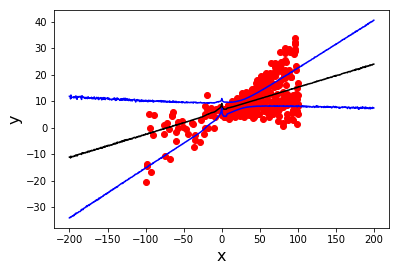

In [137]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,np.mean(n_preds,axis=0),color="black")
plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="blue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

### Case 4: Aleatoric and Epistemic Uncertainty

In [138]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
xx = tfp.layers.DenseFlipout(30,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)

xx = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(xx)

xx = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(xx)

predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(xx)


model = Model(inputs=inputs, outputs=predictions)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout_8 (DenseFlipou (None, 30)                120       
_________________________________________________________________
dense_flipout_9 (DenseFlipou (None, 20)                1240      
_________________________________________________________________
dense_flipout_10 (DenseFlipo (None, 2)                 84        
_________________________________________________________________
distribution_lambda_9 (Distr ((None, 1), (None, 1))    0         
Total params: 1,444
Trainable params: 1,444
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(x, y,batch_size=32 ,epochs=2000, verbose=0)


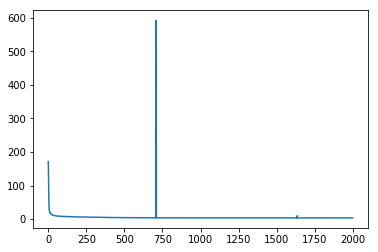

In [140]:
plt.plot(history.history['loss'])

In [0]:
#model.get_weights()

In [0]:
model_mean = tf.keras.models.Model(inputs=inputs, outputs=predictions.mean())
model_std = tf.keras.models.Model(inputs=inputs, outputs=predictions.stddev())

In [0]:
#model_mean.get_weights()

In [144]:
for i in range(0,5):
  print(model_mean.predict(x_tst[0:1]))

[[-3.3682551]]
[[9.577938]]
[[17.158176]]
[[14.841696]]
[[-24.900068]]


In [0]:
x_tst=np.arange(-100,100,0.5)

In [146]:
n=5000
n_preds=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model_mean.predict(x_tst,batch_size=150),len(x_tst))

In [148]:
n=5000
n_preds_std=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds_std[i,:]=np.reshape(model_std.predict(x_tst,batch_size=150),len(x_tst))

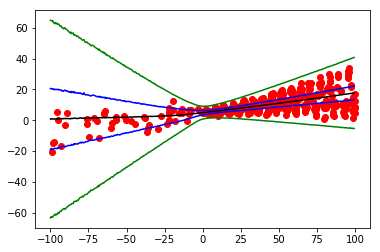

In [151]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,np.mean(n_preds,axis=0),color="black")
#plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="blue")
#plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="green")
plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="green")

In [0]:
#################
## Simulate some data 
n = 200
np.random.seed(42)
x = np.random.normal(0,1,n)
y = 3.25*x + 1 + np.random.normal(0,1,n) 

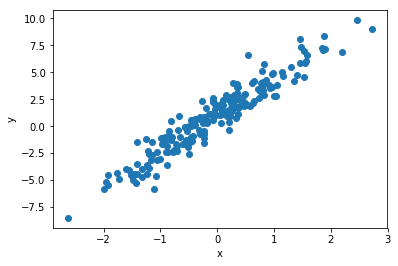

In [164]:
plt.scatter(x=x, y=y)
#plt.title("blood pressure vs age")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [0]:
data=np.vstack((x.reshape((len(x),1)),y.reshape((len(x),1))))

In [0]:
np.savetxt("x.csv", x)
np.savetxt("y.csv", y)


In [0]:
from google.colab import files
files.download('x.csv') 
files.download('y.csv') 

In [182]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
mu_x = tf.keras.layers.Dense(1)(inputs)
roh_x = tf.keras.layers.Dense(20,activation="relu")(inputs)
roh_x = tf.keras.layers.Dense(1)(roh_x)
xx = tf.keras.layers.Concatenate()([mu_x,roh_x])

predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(xx)

model = Model(inputs=inputs, outputs=predictions)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 20)           40          input_10[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 1)            2           input_10[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 1)            21          dense_19[0][0]                   
___________________________________________________________________________________________

In [0]:
model.fit(x, y, epochs=2000, verbose=False);


In [184]:
print(model(x_tst[0:1]).mean())
print(model(x_tst[0:1]).stddev())

InvalidArgumentError: ignored

In [0]:
x_tst=np.arange(-3,3,0.1)

In [0]:
x_tst=x_tst.reshape((len(x_tst),1))

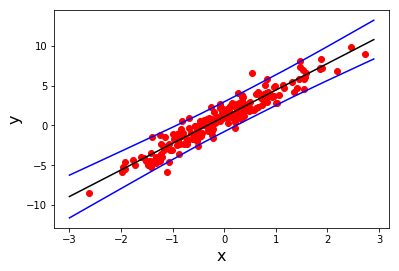

In [187]:
plt.scatter(x,y,color="red") #observerd 
#for i in range(0,3):
# plt.scatter(x_tst,model(x_tst).sample())
plt.plot(x_tst,model(x_tst).mean(),color="black")
plt.plot(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
plt.plot(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

In [198]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
xx = tfp.layers.DenseFlipout(30,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)

xx = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(xx)

xx = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(xx)

predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(xx)
#predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],scale=1))(xx)


model = Model(inputs=inputs, outputs=predictions)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_flipout_14 (DenseFlipo (None, 30)                120       
_________________________________________________________________
dense_flipout_15 (DenseFlipo (None, 20)                1240      
_________________________________________________________________
dense_flipout_16 (DenseFlipo (None, 1)                 42        
_________________________________________________________________
distribution_lambda_12 (Dist ((None, 1), (None, 1))    0         
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(x, y,batch_size=32 ,epochs=2000, verbose=0)


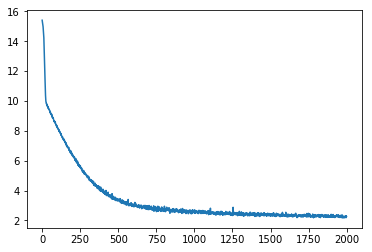

In [200]:
plt.plot(history.history['loss'])

In [0]:
model_mean = tf.keras.models.Model(inputs=inputs, outputs=predictions.mean())
model_std = tf.keras.models.Model(inputs=inputs, outputs=predictions.stddev())

In [0]:
x_tst=np.arange(-3,3,0.1)

In [203]:
n=5000
n_preds=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model_mean.predict(x_tst,batch_size=150),len(x_tst))

In [0]:
#n=5000
#n_preds_std=np.zeros((n,len(x_tst)))
#for i in tqdm(range(0,n)):
#  n_preds_std[i,:]=np.reshape(model_std.predict(x_tst,batch_size=150),len(x_tst))

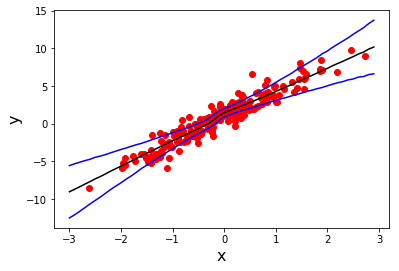

In [204]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,np.mean(n_preds,axis=0),color="black")
#plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="blue")
#plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="blue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()
#plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="green")
#plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="green")

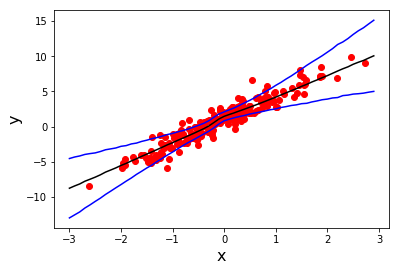

In [197]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,np.mean(n_preds,axis=0),color="black")
#plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="blue")
#plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="blue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()
#plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="green")
#plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="green")

In [205]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model



# This returns a tensor
inputs = Input(shape=(1,))
xx = tf.keras.layers.Dropout(0.2)(inputs, training=True)
xx = tf.keras.layers.Dense(30,activation="relu")(xx)
xx = tf.keras.layers.Dropout(0.2)(xx, training=True)
xx = tf.keras.layers.Dense(20,activation="relu")(xx)
xx = tf.keras.layers.Dropout(0.2)(xx, training=True)
xx = tf.keras.layers.Dense(1)(xx)



model = Model(inputs=inputs, outputs=xx)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss="mse")

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 30)                60        
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21 

In [0]:
history=model.fit(x, y,batch_size=32 ,epochs=2000, verbose=0)


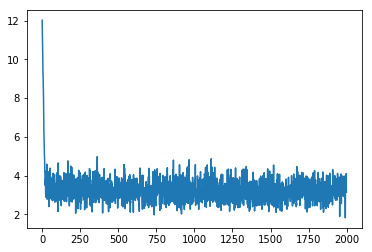

In [207]:
plt.plot(history.history['loss'])

In [208]:
for i in range(0,5):
  print(model.predict(x_tst[0:1]))

[[-7.9979286]]
[[-8.45171]]
[[1.2272571]]
[[-8.647845]]
[[-12.028084]]


In [0]:
x_tst=np.arange(-3,3,0.1)

In [210]:
n=5000
n_preds=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model.predict(x_tst,batch_size=150),len(x_tst))

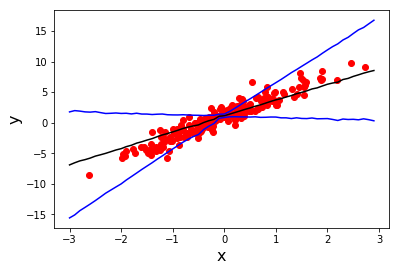

In [211]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,np.mean(n_preds,axis=0),color="black")
plt.plot(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="blue")
plt.plot(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="blue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n*2, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Build model.
model = tf.keras.Sequential([
tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable,input_shape=(1,),activation="relu"),
  #tfp.layers.DenseVariational(10, posterior_mean_field, prior_trainable),
  #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.summary()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)


NameError: ignored

In [0]:
#from IPython.display import SVG
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
#from keras.utils.vis_utils import model_to_dot
#

In [0]:
model(x_tst[0:1]).stddev()

<tf.Tensor: id=1055749, shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [0]:
model.fit(x, y, epochs=1000, verbose=False);



In [0]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
#yhat = model(x_tst)
#assert isinstance(yhat, tfd.Distribution)

[ 0.15286246  4.7040496  -3.66455    -0.52826744]
[0.13826916 4.6131687 ]


In [0]:
model.get_weights()#mitelwert von steigung und intercept und noch dazue die standartabweichung beide sind normalverteilt

[array([ 0.15286246,  4.7040496 , -3.66455   , -0.52826744], dtype=float32),
 array([0.13826916, 4.6131687 ], dtype=float32)]

In [0]:
#model(x_tst).mean()

In [0]:
#model(x_tst).stddev()

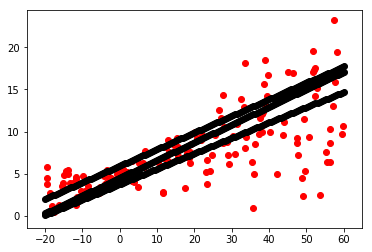

In [0]:
plt.scatter(x,y,color="red") #observerd 
#for i in range(0,3):
  #plt.scatter(x_tst,model(x_tst).sample())
for i in range(0,3):
  plt.scatter(x_tst,model(x_tst).mean(),color="black")
  #plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
  #plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
#model(x_tst).mean()

### Case 4: Aleatoric & Epistemic Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable,input_shape=(1,)),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.summary()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_18 (DenseV (None, 2)                 12        
_________________________________________________________________
distribution_lambda_31 (Dist ((None, 1), (None, 1))    0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x, y, epochs=1000, verbose=False);


In [0]:

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
#yhat = model(x_tst)
#assert isinstance(yhat, tfd.Distribution)

[ 0.12944002  2.4189117   5.1540465   2.7859828  -3.2581356  -0.65550274
 -0.56626487 -0.02603184]
[0.14465801 2.3947232  5.172522   2.651446  ]


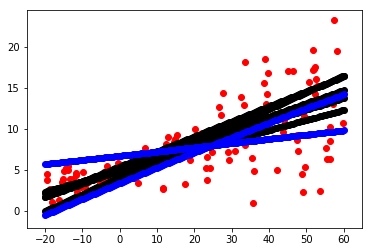

In [0]:
plt.scatter(x,y,color="red") #observerd 
#for i in range(0,3):
  #plt.scatter(x_tst,model(x_tst).sample())
for i in range(0,5):
  plt.scatter(x_tst,model(x_tst).mean(),color="black")
plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
model(x_tst).prob(5)

<tf.Tensor: id=482737, shape=(150, 1), dtype=float32, numpy=
array([[0.04425406],
       [0.05308542],
       [0.06296034],
       [0.07387467],
       [0.08580549],
       [0.09871055],
       [0.11252999],
       [0.12718761],
       [0.14259255],
       [0.15864196],
       [0.17522314],
       [0.19221663],
       [0.20949847],
       [0.22694321],
       [0.24442582],
       [0.26182547],
       [0.27902502],
       [0.2959148 ],
       [0.31239295],
       [0.32836694],
       [0.3437542 ],
       [0.35848224],
       [0.37248957],
       [0.38572463],
       [0.3981473 ],
       [0.40972653],
       [0.42044085],
       [0.43027762],
       [0.4392323 ],
       [0.4473077 ],
       [0.45451325],
       [0.46086413],
       [0.46638042],
       [0.47108632],
       [0.47501034],
       [0.47818303],
       [0.48063767],
       [0.48240882],
       [0.48353267],
       [0.48404598],
       [0.48398572],
       [0.48338884],
       [0.48229215],
       [0.4807313 ],
       [0.47874